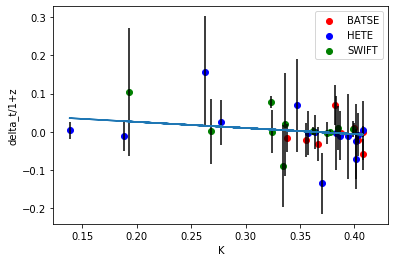

In [2]:
#Ellis data linear fit.

import numpy as np
from numpy import genfromtxt
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
df = genfromtxt('C:\\Users\\Rajdeep Agrawal\\Downloads\\Ellis_data - Sheet1.csv', delimiter=',')
z = df[:,0]
delta_t = df[:,1]
err = df[:,2]
y = []
x_fit = []

for i in range(0,df.shape[0]):
    y = np.append(y, delta_t[i]/(1+z[i]))
    res = quad(lambda x: 1/((0.3*(x+1)**3+0.7)**0.5), 0, z[i])
    x_fit = np.append(x_fit, (1/(1+z[i]))*res[0])

def func(x,a,b):
    return a*x + b

params,_ = curve_fit(func, x_fit, y, sigma=err)
y_fit = params[0]*x_fit + params[1]
x_BATSE = x_fit[:9]
y_BATSE = y[:9]
x_HETE = x_fit[9:24]
y_HETE = y[9:24]
x_SWIFT = x_fit[24:]
y_SWIFT = y[24:]
plt.scatter(x_BATSE, y_BATSE, color='red', label='BATSE')
plt.scatter(x_HETE, y_HETE, color='blue', label='HETE')
plt.scatter(x_SWIFT, y_SWIFT, color='green', label='SWIFT')
plt.plot(x_fit, y_fit)
plt.errorbar(x_fit, y, yerr=err, fmt=' ', color='black')
plt.legend()
plt.xlabel('K')
plt.ylabel('delta_t/1+z')
plt.show()


In [3]:
#W17 data: GRB160625B analysis

from scipy import stats
data = genfromtxt('C:\\Users\\Rajdeep Agrawal\\Downloads\\W17_data - Sheet1.csv', delimiter=',')
delta_E = data[:,0]
delta_t = data[:,1]
err = data[:,2]
residue = []
z = 1.41             #approx redshift of GRB160625B
H0 = 67.3
integ1, err1 = quad(lambda x: (1+x)/((0.315*(1+x)**3 + 0.685)**0.5), 0, z)  #integral term for n=1
integ2, err2 = quad(lambda y: (1+y)**2/((0.315*(1+y)**3 + 0.685)**0.5), 0, z) #integral term for n=2
print(integ1, integ2)

def null_hypo(E, tau, alpha):  #null hypothesis function without LIV.
    return tau*(E**alpha - 11.34**alpha)

def linear_LIV(E, E_QG, tau, alpha): #n=1 function.
    return tau*(E**alpha - 11.34**alpha) + (-1/(H0*3.24*10**-14))*integ1*((E - 11.34)/E_QG)

def quadratic_LIV(E, E_QG, tau, alpha): #n=2 function.
    return tau*(E**alpha - 11.34**alpha) + (-3/(2*H0*3.24*10**-8))*integ2*((E**2 - 11.34**2)/E_QG**2)

#fitting above functions to obtain optimized parameters.
params1,_ = curve_fit(null_hypo, delta_E, delta_t, sigma = err)
params2, cov1 = curve_fit(linear_LIV, delta_E, delta_t, sigma = err, maxfev=2000)
params3, cov2 = curve_fit(quadratic_LIV, delta_E, delta_t, sigma = err, maxfev=40000)

#compute minimised chi2 values for all 3 models.
def compute_chi2(n):
    chi2_min = 0
    if n==0:
        for i in range(0,data.shape[0]):
            chi2_min = chi2_min + ((delta_t[i] - null_hypo(delta_E[i], params1[0], params1[1]))/err[i])**2
    elif n==1:
        for i in range(0,data.shape[0]):
            chi2_min = chi2_min + ((delta_t[i] - linear_LIV(delta_E[i], params2[0], params2[1], params2[2]))/err[i])**2
    else:
        for i in range(0,data.shape[0]):
            chi2_min = chi2_min + ((delta_t[i] - quadratic_LIV(delta_E[i], params3[0], params3[1], params3[2]))/err[i])**2
    return chi2_min

def residual(n, residue):
    if n==0:
        for i in range(0,data.shape[0]):
            residue = np.append(residue, (delta_t[i] - null_hypo(delta_E[i], params1[0], params1[1]))/err[i])
    if n==1:
        for i in range(0,data.shape[0]):
            residue = np.append(residue, (delta_t[i] - linear_LIV(delta_E[i], params2[0], params2[1], params2[2]))/err[i])
    else:
        for i in range(0,data.shape[0]):
            residue = np.append(residue, (delta_t[i] - quadratic_LIV(delta_E[i], params3[0], params3[1], params3[2]))/err[i])
    return residue
        
#compute p-values and Z-scores
p_value1 = 1 - stats.chi2(1).cdf(compute_chi2(0) - compute_chi2(1)) #for n=1 assuming null hypo
p_value2 = 1 - stats.chi2(1).cdf(compute_chi2(0) - compute_chi2(2)) #for n=2 assuming null hypo
print(p_value1, p_value2)
print(stats.norm.isf(p_value1))
print(stats.norm.isf(p_value2))

#computing AIC and BIC values
AIC_c1 = compute_chi2(0) + 4 + (12/data.shape[0]-3)
AIC_c2 = compute_chi2(1) + 6 + (24/data.shape[0]-4)
AIC_c3 = compute_chi2(2) + 6 + (24/data.shape[0]-4)
print(AIC_c1 - AIC_c2)
print(AIC_c1 - AIC_c3)

BIC1 = compute_chi2(0) + 2*np.log(data.shape[0])
BIC2 = compute_chi2(1) + 3*np.log(data.shape[0])
BIC3 = compute_chi2(2) + 3*np.log(data.shape[0])
print(BIC1-BIC2)
print(BIC1-BIC3)
print(params1,params2, params3)
print(compute_chi2(0)/(data.shape[0]-2), compute_chi2(1)/(data.shape[0]-3), compute_chi2(2)/(data.shape[0]-3)) 

1.557936221378215 2.6603972185674114
0.0011430647170040942 9.196850302284343e-05
3.050299923320545
3.7401137364240014
9.25585661205902
13.970492748569214
6.969263023739117
11.683899160249311
[5.86513912 0.05860808] [4.71528606e+15 1.27565597e+00 1.72384419e-01] [1.47875043e+07 2.21429022e+00 1.19291056e-01]
2.6038724096748873 2.369275100065815 2.230609331344927


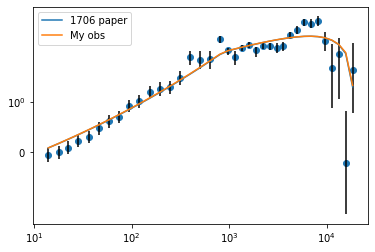

In [3]:
#n=2 fit on W17 data
plt.scatter(delta_E, delta_t)
plt.errorbar(delta_E, delta_t, yerr=err, fmt=' ', color='black')

y_Sh = quadratic_LIV(delta_E, 1.47*10**7, 2.13, 0.122)
plt.plot(delta_E, y_Sh, label='1706 paper')
y_obs = quadratic_LIV(delta_E, params3[0], params3[1], params3[2])
plt.plot(delta_E, y_obs, label='My obs')

plt.yscale('symlog')
plt.xscale('symlog')
plt.legend()

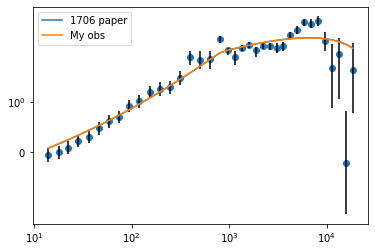

In [4]:
#n=1 fit on W17 data
plt.scatter(delta_E, delta_t)
plt.errorbar(delta_E, delta_t, yerr=err, fmt=' ', color='black')

y_Sh = linear_LIV(delta_E, 4.7*10**15, 1.24, 0.175)
plt.plot(delta_E, y_Sh, label='1706 paper')
y_obs = linear_LIV(delta_E, params2[0], params2[1], params2[2])
plt.plot(delta_E, y_obs, label='My obs')

plt.yscale('symlog')
plt.xscale('symlog')
plt.legend()

In [71]:
#Generating best fit parameters using MCMC sampling for n=1
import emcee
from scipy.optimize import minimize

def log_likelihood1(theta, delta_E, delta_t, err):
    E_QG1, tau, alpha = theta
    model = linear_LIV(delta_E, E_QG1, tau, alpha)
    return -0.5 * np.sum((delta_t - model)**2 / err**2)

np.random.seed(42)
nll = lambda *args: -log_likelihood1(*args)
initial = np.array([params2[0], params2[1], params2[2]]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(delta_E, delta_t, err))
print(soln.x)

def log_prior1(theta): #flat prior.
    E_QG1, tau, alpha = theta
    if 140.0 < E_QG1 < 160.0 and 1.0 < tau < 2.0 and 0.0 < alpha < 1.0:
        return 0
    return -np.inf

def log_posterior1(theta, delta_E, delta_t, err):
    lp = log_prior1(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood1(theta, delta_E, delta_t, err)

nsteps = 20000
nburn = 5000
np.random.seed(0)
init_guess = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = init_guess.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior1, args=(delta_E, delta_t, err))
sampler.run_mcmc(init_guess, nsteps, progress=True)
smp = sampler.get_chain()
print(sampler.get_chain())
print(smp[:,0,0])


[152.77649081   1.27568191   0.17238248]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:25<00:00, 792.77it/s]

[[[1.52776609e+02 1.27570394e+00 1.72417564e-01]
  [1.52776868e+02 1.27606624e+00 1.72236222e-01]
  [1.52776627e+02 1.27569726e+00 1.72388537e-01]
  ...
  [1.52776473e+02 1.27557483e+00 1.72487924e-01]
  [1.52776511e+02 1.27577072e+00 1.72429717e-01]
  [1.52776587e+02 1.27571595e+00 1.72453206e-01]]

 [[1.52776709e+02 1.27579872e+00 1.72365913e-01]
  [1.52777121e+02 1.27623263e+00 1.72150000e-01]
  [1.52776689e+02 1.27568482e+00 1.72388268e-01]
  ...
  [1.52776473e+02 1.27557483e+00 1.72487924e-01]
  [1.52776511e+02 1.27577072e+00 1.72429717e-01]
  [1.52776682e+02 1.27571982e+00 1.72329643e-01]]

 [[1.52776903e+02 1.27586624e+00 1.72139564e-01]
  [1.52777217e+02 1.27633817e+00 1.72178255e-01]
  [1.52776658e+02 1.27566875e+00 1.72402830e-01]
  ...
  [1.52776606e+02 1.27569544e+00 1.72573505e-01]
  [1.52776512e+02 1.27577116e+00 1.72427117e-01]
  [1.52776916e+02 1.27574158e+00 1.71997661e-01]]

 ...

 [[1.42500217e+02 1.93654988e+00 1.39399361e-01]
  [1.47737436e+02 1.08525995e+00 1.8701

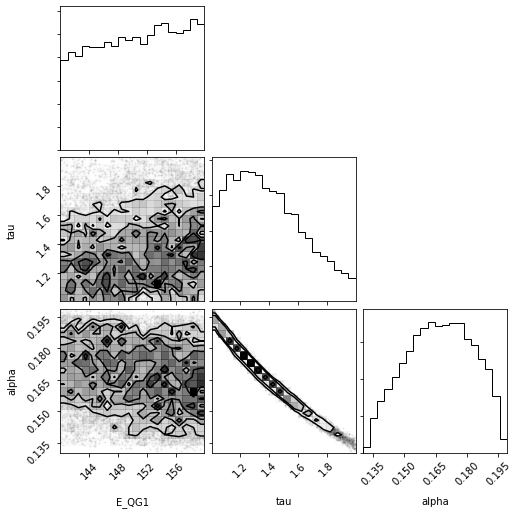

In [66]:
#Corner plot for best fit parameters
import corner
flat_samples = sampler.get_chain(discard=nburn, thin=50, flat=True)
fig = corner.corner(flat_samples, labels=('E_QG1','tau','alpha'))

In [47]:
#Generating best fit parameters using MCMC sampling for n=2
def log_likelihood2(theta, delta_E, delta_t, err):
    E_QG2, tau, alpha = theta
    model = quadratic_LIV(delta_E, E_QG2, tau, alpha)
    return -0.5 * np.sum((delta_t - model)**2 / err**2)

np.random.seed(42)
nll = lambda *args: -log_likelihood2(*args)
initial = np.array([params3[0], params3[1], params3[2]]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(delta_E, delta_t, err))

def log_prior2(theta): #flat prior.
    E_QG2, tau, alpha = theta
    if 1000.0 < E_QG2 < 10000.0 and -10000.0 < tau < -1000.0 and -10.0 < alpha < 10.0:
        return 0
    return -np.inf

def log_posterior2(theta, delta_E, delta_t, err):
    lp = log_prior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood2(theta, delta_E, delta_t, err)

nsteps = 100000
nburn = 2000
np.random.seed(0)
init_guess = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = init_guess.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, args=(delta_E, delta_t, err))
sampler.run_mcmc(init_guess, nsteps, progress=True)
print(sampler.get_chain())
smp = sampler.get_chain()
print(sampler.get_chain())
print(smp[:,0,0])

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]D:\ProgramData\Anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:27<00:00, 1148.12it/s]

[[[ 3.32977609e+08 -7.83142118e+02 -4.81325547e-04]
  [ 3.32977609e+08 -7.83141971e+02 -6.76927133e-04]
  [ 3.32977609e+08 -7.83142173e+02 -5.89521230e-04]
  ...
  [ 3.32977609e+08 -7.83142265e+02 -4.73754173e-04]
  [ 3.32977609e+08 -7.83142036e+02 -5.58371847e-04]
  [ 3.32977609e+08 -7.83142122e+02 -5.08542028e-04]]

 [[ 3.32977609e+08 -7.83142118e+02 -4.81325547e-04]
  [ 3.32977609e+08 -7.83141971e+02 -6.76927133e-04]
  [ 3.32977609e+08 -7.83142173e+02 -5.89521230e-04]
  ...
  [ 3.32977609e+08 -7.83142265e+02 -4.73754173e-04]
  [ 3.32977609e+08 -7.83142036e+02 -5.58371847e-04]
  [ 3.32977609e+08 -7.83142122e+02 -5.08542028e-04]]

 [[ 3.32977609e+08 -7.83142118e+02 -4.81325547e-04]
  [ 3.32977609e+08 -7.83141971e+02 -6.76927133e-04]
  [ 3.32977609e+08 -7.83142173e+02 -5.89521230e-04]
  ...
  [ 3.32977609e+08 -7.83142265e+02 -4.73754173e-04]
  [ 3.32977609e+08 -7.83142036e+02 -5.58371847e-04]
  [ 3.32977609e+08 -7.83142122e+02 -5.08542028e-04]]

 ...

 [[ 3.32977609e+08 -7.83142118e+02

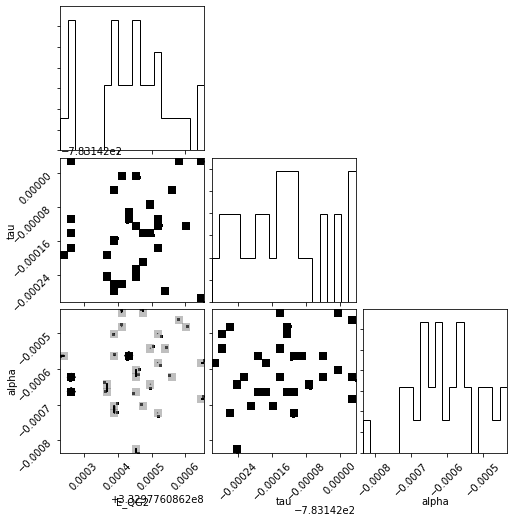

In [46]:
flat_samples = sampler.get_chain(discard=nburn, thin=50, flat=True)
fig = corner.corner(flat_samples, labels=('E_QG2','tau','alpha'))

In [4]:
#Analysis including other redshifts from Ellis' data.

data = genfromtxt('C:\\Users\\Rajdeep Agrawal\\Downloads\\newcombineddata.csv', delimiter=',')
E0 = data[:,0]
delta_E_comb = data[:,1]
delta_t_comb = data[:,2]
sigma_t = data[:,3]
z_com = data[:,4]
H0 = 67.3
def K(z, n):
    f = lambda x: ((1+x)**n)/((0.315*(1+x)**3 + 0.685)**0.5)
    return quad(f, 0, z)

K_vec = np.vectorize(K)
init_vals_1 = [1e15,1.0,0.1]
init_vals_2 = [1e7,2.0,0.1]
def linear(X, E_qg, tau, alpha):
    E, z, E0 = X    #unpacking independent parameters.
    K_z,err = K_vec(z,1)
    return (1+z)*tau*(E**alpha - E0**alpha) + (-(10**14)/(H0*3.24))*((E - E0)*K_z/E_qg)

def quadratic(X, E_qg, tau, alpha):
    E, z, E0 = X  #unpacking independent parameters.
    K_z,err = K_vec(z,2)
    return (1+z)*tau*(E**alpha - E0**alpha) + (-3/(2*H0*3.24*10**-8))*((E**2 - E0**2)*K_z/E_qg**2)

params1_comb,_ = curve_fit(linear, (delta_E_comb, z_com, E0), delta_t_comb, sigma=sigma_t, p0=init_vals_1)
params2_comb,_ = curve_fit(quadratic, (delta_E_comb, z_com, E0), delta_t_comb, sigma=sigma_t, p0=init_vals_2)

print('Parameters for n=1 with combined data:')
print('E_QG:',params1_comb[0])
print('tau:',params1_comb[1])
print('alpha:', params1_comb[2])
print('\nParameters for n=2 with combined data:')
print('E_QG:',params2_comb[0])
print('tau:',params2_comb[1])
print('alpha:', params2_comb[2])
#Each 3-tuple of parameters in the order: (E_QG, tau, alpha)

Parameters for n=1 with combined data:
E_QG: 3836819701952938.0
tau: 3.256208788325723e-05
alpha: 1.2185695537649992

Parameters for n=2 with combined data:
E_QG: 2040062.0031225528
tau: 1.0217545455611018e-06
alpha: 1.824326720825807
